# Simplified P2P Federated Learning Analysis

This notebook analyzes the 5 essential metrics for decentralized P2P experiments:
1. **Accuracy** of each client overall for each round
2. **Accuracy per class** of each client for each round
3. **Loss** per round of each client
4. **Gradient norm** of each client per round
5. **Gradient changes** per round of each client

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import os

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


## Load Experiment Data

In [96]:
def load_latest_experiments(logs_dir="logs"):
    """
    Load CSVs from the latest experiment of each comparison method,
    ignoring centralized_fedavg.
    """
    dfs = {}

    IGNORE_DIRS = {"centralized_fedavg"}

    for method_dir in os.listdir(logs_dir):
        if method_dir in IGNORE_DIRS:
            continue

        method_path = os.path.join(logs_dir, method_dir)

        if not os.path.isdir(method_path):
            continue

        # Get all experiment folders
        experiments = [
            d for d in os.listdir(method_path)
            if os.path.isdir(os.path.join(method_path, d))
        ]

        if not experiments:
            continue

        # Latest experiment (timestamp format sorts correctly)
        latest_exp = max(experiments)
        latest_path = os.path.join(method_path, latest_exp)

        # Method name cleanup
        method_name = method_dir.replace("_comparison", "")

        # Expected CSVs
        csv_files = {
            "p2p_metrics.csv": f"{method_name}_p2p_metrics_df",
            "p2p_per_class_metrics.csv": f"{method_name}_p2p_per_class_df"
        }

        for csv_file, df_name in csv_files.items():
            csv_path = os.path.join(latest_path, csv_file)

            if os.path.exists(csv_path):
                dfs[df_name] = pd.read_csv(csv_path)

    return dfs

dfs = load_latest_experiments("logs")

jaccard_p2p_metrics_df = dfs["jaccard_p2p_metrics_df"]
jaccard_p2p_per_class_df = dfs["jaccard_p2p_per_class_df"]

matcha_p2p_metrics_df = dfs["matcha_p2p_metrics_df"]
matcha_p2p_per_class_df = dfs["matcha_p2p_per_class_df"]

max_degree_p2p_metrics_df = dfs["max_degree_p2p_metrics_df"]
max_degree_p2p_per_class_df = dfs["max_degree_p2p_per_class_df"]

metropolis_p2p_metrics_df = dfs["metropolis_hastings_p2p_metrics_df"]
metropolis_p2p_per_class_df = dfs["metropolis_hastings_p2p_per_class_df"]

metropolis_p2p_metrics_df.columns, metropolis_p2p_per_class_df.columns



(Index(['client_id', 'round', 'cluster_id', 'test_accuracy', 'test_loss',
        'gradient_norm', 'gradient_change'],
       dtype='str'),
 Index(['client_id', 'round', 'cluster_id', 'class_id', 'class_accuracy',
        'class_precision', 'class_recall', 'class_f1_score'],
       dtype='str'))

## AVG Test Accuracy per round

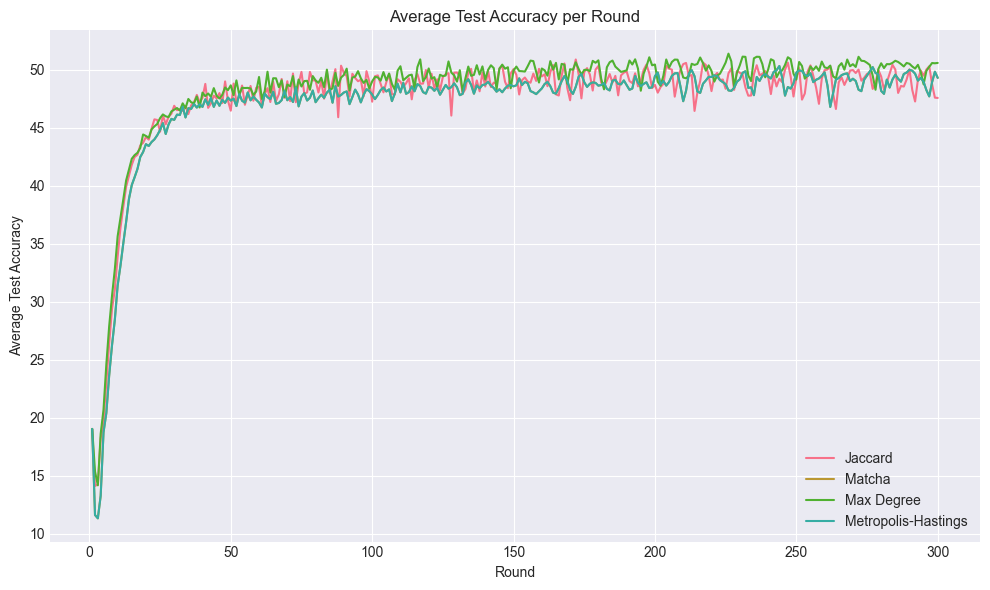

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Jaccard
jaccard_avg = (
    jaccard_p2p_metrics_df
    .groupby("round")["test_accuracy"]
    .mean()
    .sort_index()
)
plt.plot(jaccard_avg.index, jaccard_avg.values, label="Jaccard")

# Matcha
matcha_avg = (
    matcha_p2p_metrics_df
    .groupby("round")["test_accuracy"]
    .mean()
    .sort_index()
)
plt.plot(matcha_avg.index, matcha_avg.values, label="Matcha")

# Max Degree
max_degree_avg = (
    max_degree_p2p_metrics_df
    .groupby("round")["test_accuracy"]
    .mean()
    .sort_index()
)
plt.plot(max_degree_avg.index, max_degree_avg.values, label="Max Degree")

# Metropolis-Hastings
metropolis_avg = (
    metropolis_p2p_metrics_df
    .groupby("round")["test_accuracy"]
    .mean()
    .sort_index()
)
plt.plot(metropolis_avg.index, metropolis_avg.values, label="Metropolis-Hastings")

plt.xlabel("Round")
plt.ylabel("Average Test Accuracy")
plt.title("Average Test Accuracy per Round")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## AVG Train vs Test Accuracy per Round

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

methods = {
    "Jaccard": jaccard_p2p_metrics_df,
    "Matcha": matcha_p2p_metrics_df,
    "Max Degree": max_degree_p2p_metrics_df,
    "Metropolis-Hastings": metropolis_p2p_metrics_df
}

# Left plot: Train vs Test Accuracy
for name, df_method in methods.items():
    if 'train_accuracy' in df_method.columns:
        train_avg = df_method.groupby("round")["train_accuracy"].mean().sort_index()
        axes[0].plot(train_avg.index, train_avg.values, linestyle='--', alpha=0.7, label=f"{name} (Train)")
    test_avg = df_method.groupby("round")["test_accuracy"].mean().sort_index()
    axes[0].plot(test_avg.index, test_avg.values, label=f"{name} (Test)")

axes[0].set_xlabel("Round")
axes[0].set_ylabel("Average Accuracy")
axes[0].set_title("Train vs Test Accuracy per Round")
axes[0].legend(fontsize=8)
axes[0].grid(True)

# Right plot: Train vs Test Loss
for name, df_method in methods.items():
    if 'train_loss' in df_method.columns:
        train_avg = df_method.groupby("round")["train_loss"].mean().sort_index()
        axes[1].plot(train_avg.index, train_avg.values, linestyle='--', alpha=0.7, label=f"{name} (Train)")
    test_avg = df_method.groupby("round")["test_loss"].mean().sort_index()
    axes[1].plot(test_avg.index, test_avg.values, label=f"{name} (Test)")

axes[1].set_xlabel("Round")
axes[1].set_ylabel("Average Loss")
axes[1].set_title("Train vs Test Loss per Round")
axes[1].legend(fontsize=8)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print generalization gap (train - test accuracy) for final round
print("\nGeneralization Gap (Train Acc - Test Acc) at Final Round:")
for name, df_method in methods.items():
    if 'train_accuracy' in df_method.columns:
        final_round = df_method['round'].max()
        final = df_method[df_method['round'] == final_round]
        gap = final['train_accuracy'].mean() - final['test_accuracy'].mean()
        print(f"  {name}: {gap:.2f}%")

## 1. Overall Accuracy per Client

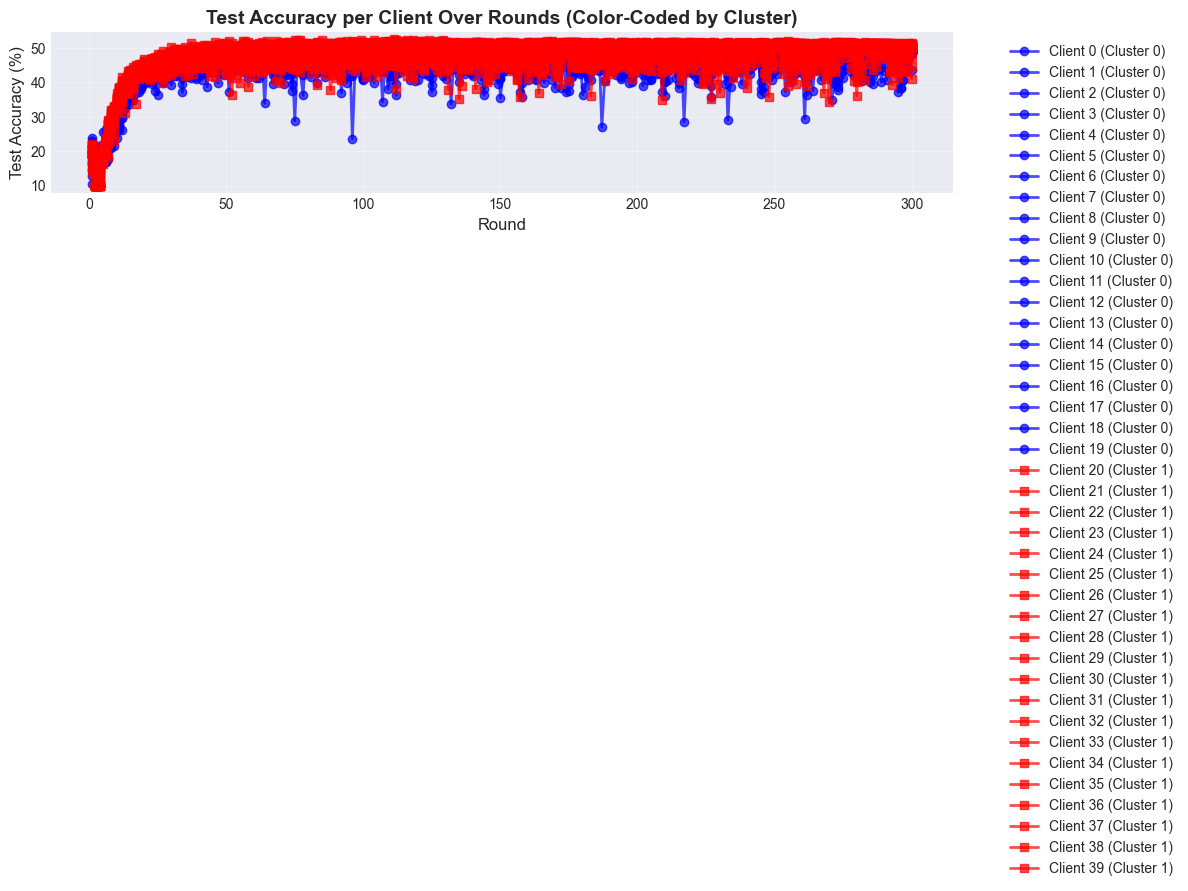


Final Round Accuracy:
  Mean: 49.30%
  Std: 2.08%
  Min: 41.08% (Client 37)
  Max: 51.34% (Client 29)

Cluster-wise Accuracy:
  Cluster 0: 48.83% ± 1.29%
  Cluster 1: 49.76% ± 2.60%


In [72]:
plt.figure(figsize=(12, 6))

# Define colors and markers for each cluster
cluster_colors = {0: 'blue', 1: 'red', None: 'gray'}
cluster_markers = {0: 'o', 1: 's', None: '^'}
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', None: 'No Cluster'}

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 'o')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data['round'], client_data['test_accuracy'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Test Accuracy per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
final_round = df['round'].max()
final_acc = df[df['round'] == final_round].groupby('client_id')['test_accuracy'].first()
print(f"\nFinal Round Accuracy:")
print(f"  Mean: {final_acc.mean():.2f}%")
print(f"  Std: {final_acc.std():.2f}%")
print(f"  Min: {final_acc.min():.2f}% (Client {final_acc.idxmin()})")
print(f"  Max: {final_acc.max():.2f}% (Client {final_acc.idxmax()})")

# Cluster-wise statistics if available
if 'cluster_id' in df.columns:
    final_data = df[df['round'] == final_round]
    print(f"\nCluster-wise Accuracy:")
    for cluster_id in sorted(final_data['cluster_id'].dropna().unique()):
        cluster_acc = final_data[final_data['cluster_id'] == cluster_id]['test_accuracy']
        print(f"  Cluster {int(cluster_id)}: {cluster_acc.mean():.2f}% ± {cluster_acc.std():.2f}%")

## 2. Loss per Client

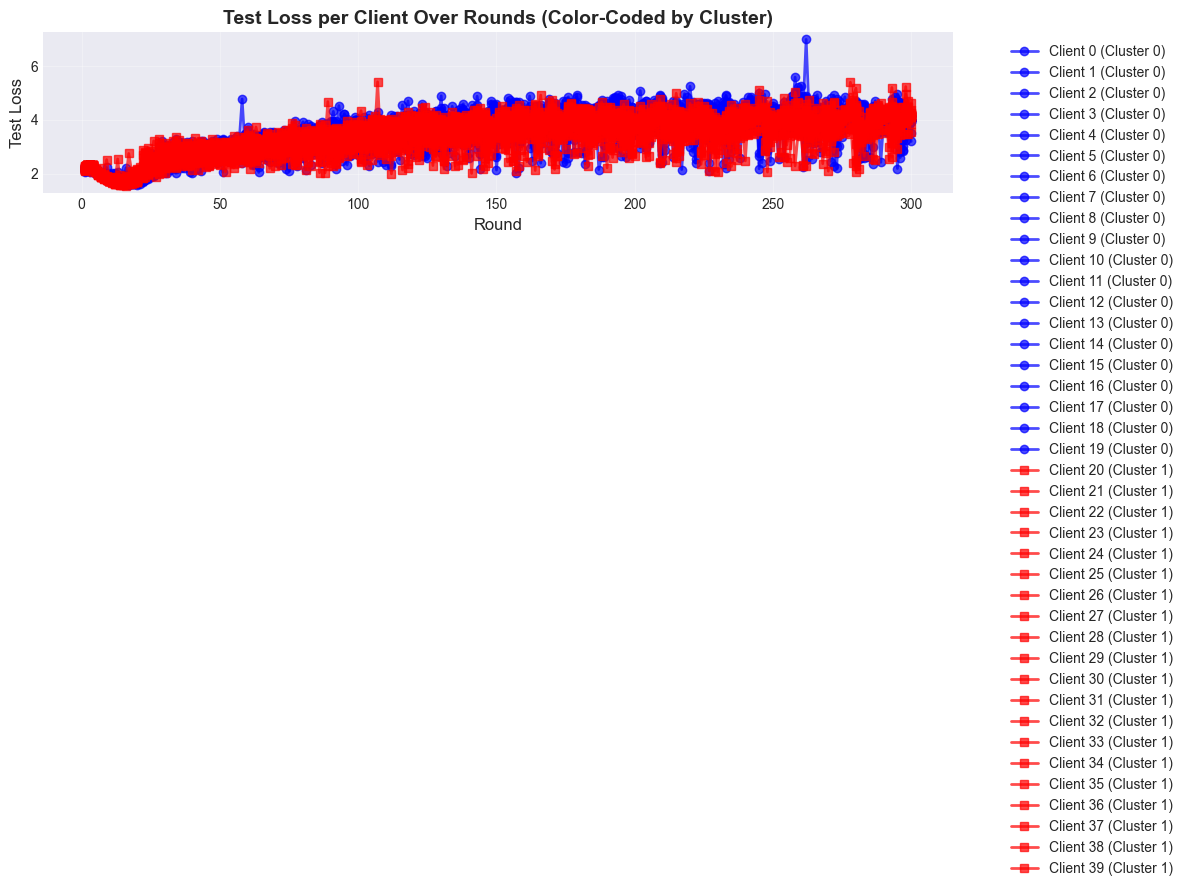


Final Round Loss:
  Mean: 4.0597
  Std: 0.2355
  Min: 3.1923 (Client 8)
  Max: 4.6287 (Client 27)


In [73]:
plt.figure(figsize=(12, 6))

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 's')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data['round'], client_data['test_loss'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
final_loss = df[df['round'] == final_round].groupby('client_id')['test_loss'].first()
print(f"\nFinal Round Loss:")
print(f"  Mean: {final_loss.mean():.4f}")
print(f"  Std: {final_loss.std():.4f}")
print(f"  Min: {final_loss.min():.4f} (Client {final_loss.idxmin()})")
print(f"  Max: {final_loss.max():.4f} (Client {final_loss.idxmax()})")

## 3. Gradient Norm per Client

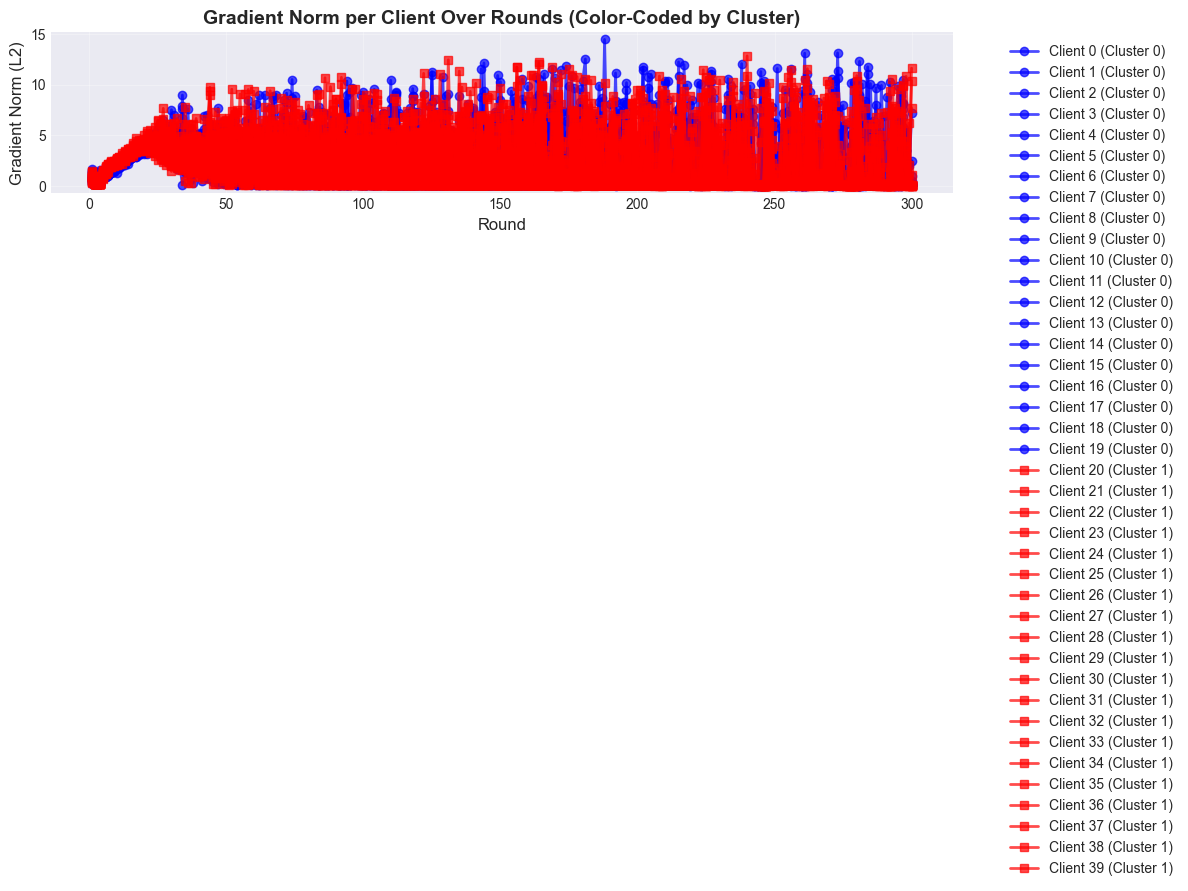


Final Round Gradient Norm:
  Mean: 1.1007
  Std: 2.8387
  Min: 0.0343 (Client 21)
  Max: 11.6254 (Client 23)


In [74]:
plt.figure(figsize=(12, 6))

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, '^')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data['round'], client_data['gradient_norm'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Gradient Norm (L2)', fontsize=12)
plt.title('Gradient Norm per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
final_grad = df[df['round'] == final_round].groupby('client_id')['gradient_norm'].first()
print(f"\nFinal Round Gradient Norm:")
print(f"  Mean: {final_grad.mean():.4f}")
print(f"  Std: {final_grad.std():.4f}")
print(f"  Min: {final_grad.min():.4f} (Client {final_grad.idxmin()})")
print(f"  Max: {final_grad.max():.4f} (Client {final_grad.idxmax()})")

## 4. Gradient Changes per Client

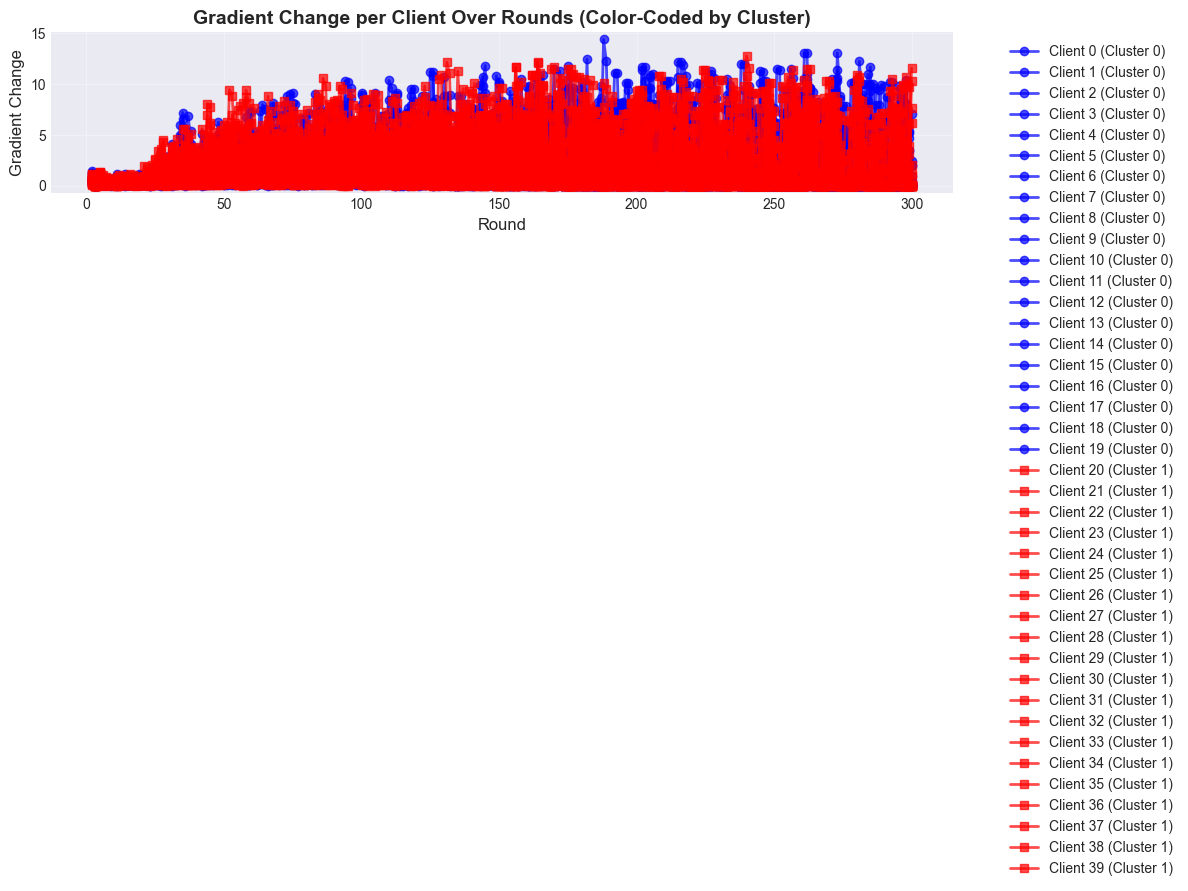


Gradient change shows how much the gradient norm changed from the previous round.
Lower values indicate convergence (gradients stabilizing).


In [75]:
plt.figure(figsize=(12, 6))

for client_id in sorted(df['client_id'].unique()):
    client_data = df[df['client_id'] == client_id]
    # Skip first round (gradient_change = 0)
    client_data_filtered = client_data[client_data['round'] > 1]
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 'd')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data_filtered['round'], client_data_filtered['gradient_change'], 
             marker=marker, linewidth=2, label=f'Client {client_id} ({cluster_label})',
             color=color, alpha=0.7)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Gradient Change', fontsize=12)
plt.title('Gradient Change per Client Over Rounds (Color-Coded by Cluster)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nGradient change shows how much the gradient norm changed from the previous round.")
print("Lower values indicate convergence (gradients stabilizing).")

## 5. Per-Class Accuracy for Each Client

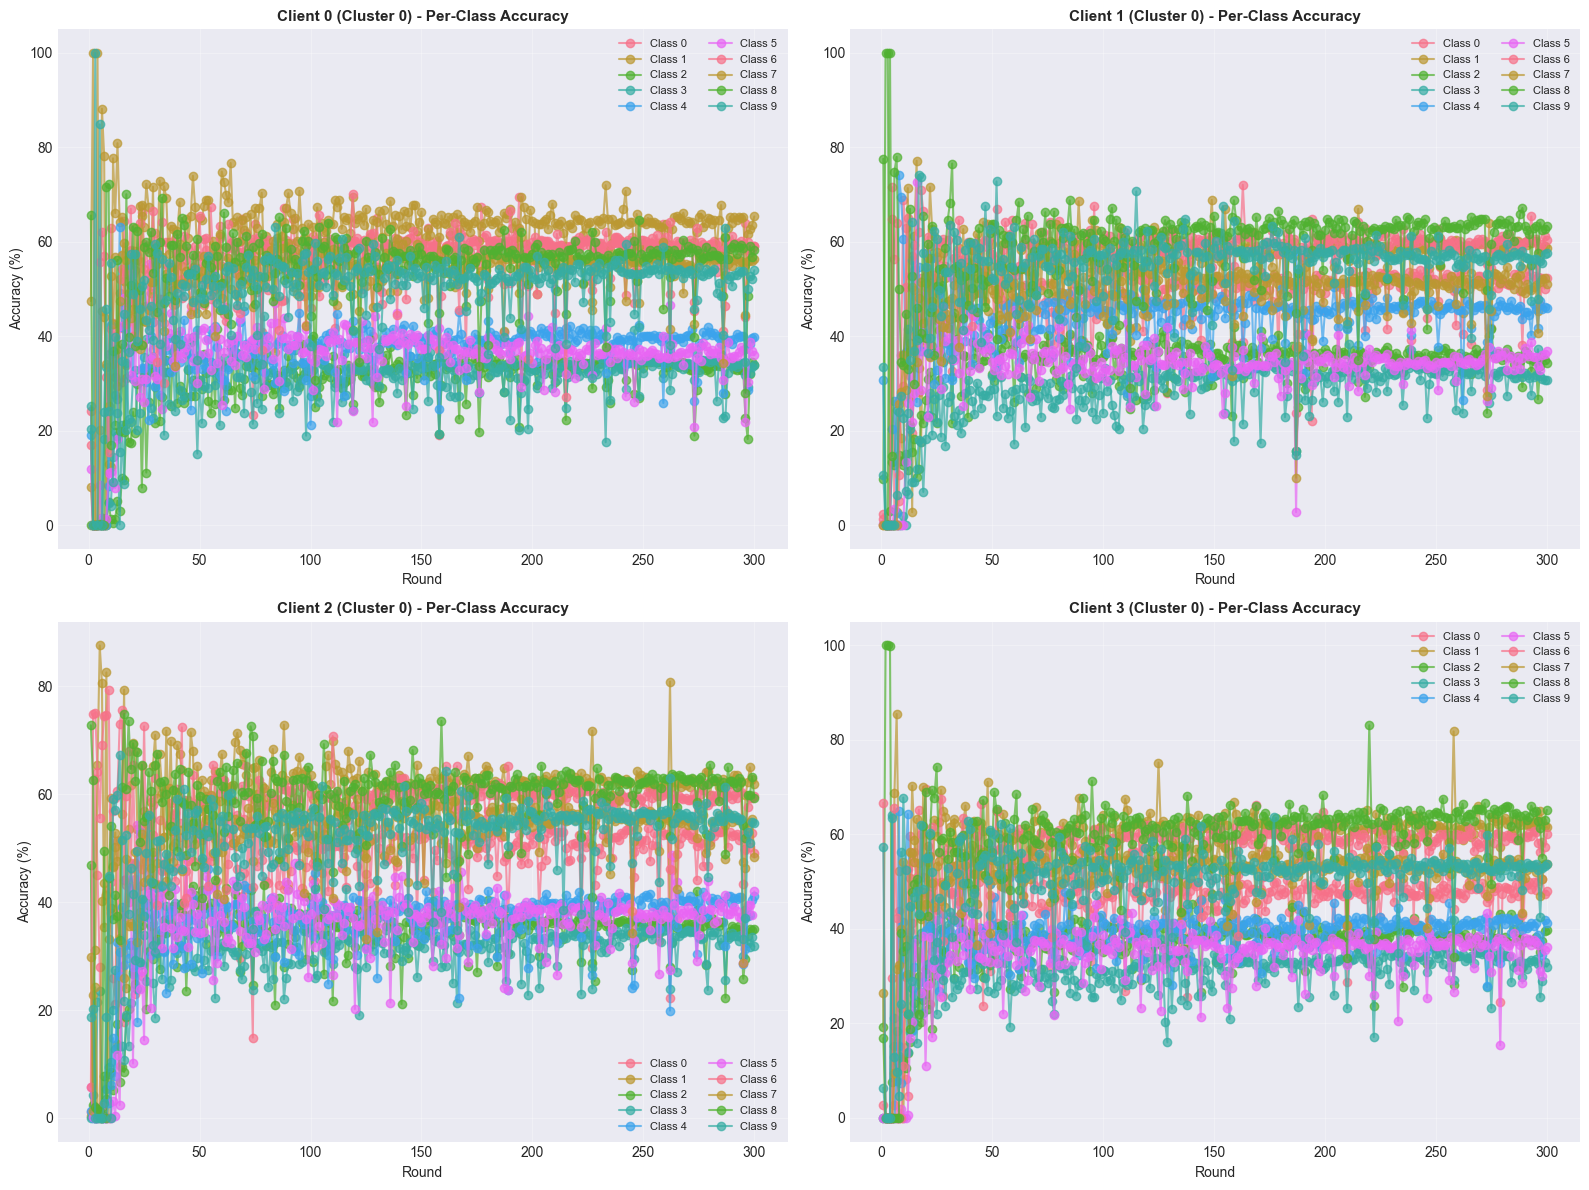

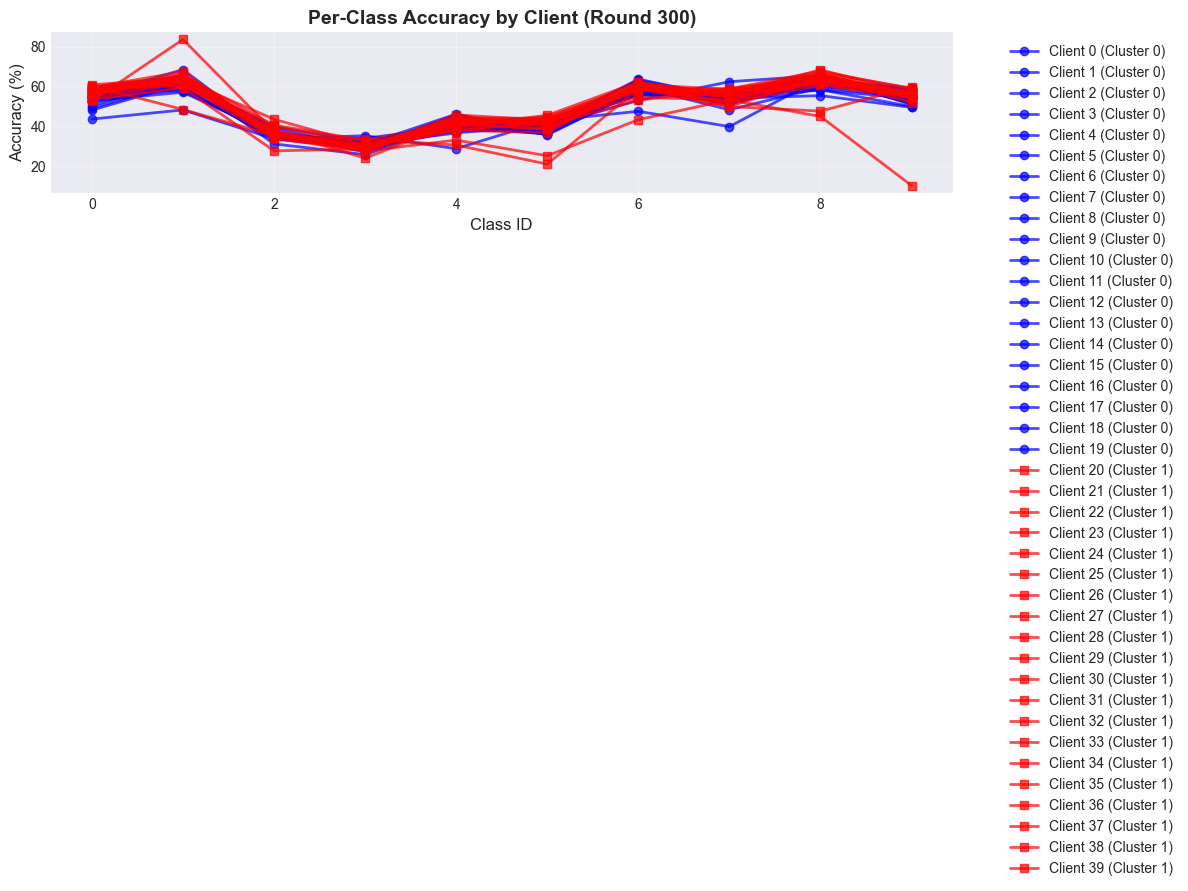

In [76]:
# Plot per-class accuracy for each client separately
num_clients = df_class['client_id'].nunique()
num_classes = df_class['class_id'].nunique()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, client_id in enumerate(sorted(df_class['client_id'].unique())):
    if idx >= 4:  # Only plot first 4 clients if more exist
        break
    
    ax = axes[idx]
    client_class_data = df_class[df_class['client_id'] == client_id]
    cluster_id = client_class_data['cluster_id'].iloc[0] if 'cluster_id' in df_class.columns else None
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    for class_id in sorted(client_class_data['class_id'].unique()):
        class_data = client_class_data[client_class_data['class_id'] == class_id]
        ax.plot(class_data['round'], class_data['class_accuracy'], 
               marker='o', linewidth=1.5, alpha=0.7, label=f'Class {class_id}')
    
    ax.set_xlabel('Round', fontsize=10)
    ax.set_ylabel('Accuracy (%)', fontsize=10)
    ax.set_title(f'Client {client_id} ({cluster_label}) - Per-Class Accuracy', fontsize=11, fontweight='bold')
    ax.legend(ncol=2, fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Per-class accuracy line plot (final round) - color-coded by cluster
final_class_data = df_class[df_class['round'] == final_round]

plt.figure(figsize=(12, 6))
for client_id in sorted(final_class_data['client_id'].unique()):
    client_data = final_class_data[final_class_data['client_id'] == client_id]
    client_data_sorted = client_data.sort_values('class_id')
    cluster_id = client_data['cluster_id'].iloc[0] if 'cluster_id' in df_class.columns else None
    
    color = cluster_colors.get(cluster_id, 'gray')
    marker = cluster_markers.get(cluster_id, 'o')
    cluster_label = cluster_labels.get(cluster_id, 'Unknown')
    
    plt.plot(client_data_sorted['class_id'], client_data_sorted['class_accuracy'], 
            marker=marker, linewidth=2, alpha=0.7, 
            label=f'Client {client_id} ({cluster_label})',
            color=color)

plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Per-Class Accuracy by Client (Round {final_round})', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Per-Class Precision, Recall, F1-Score

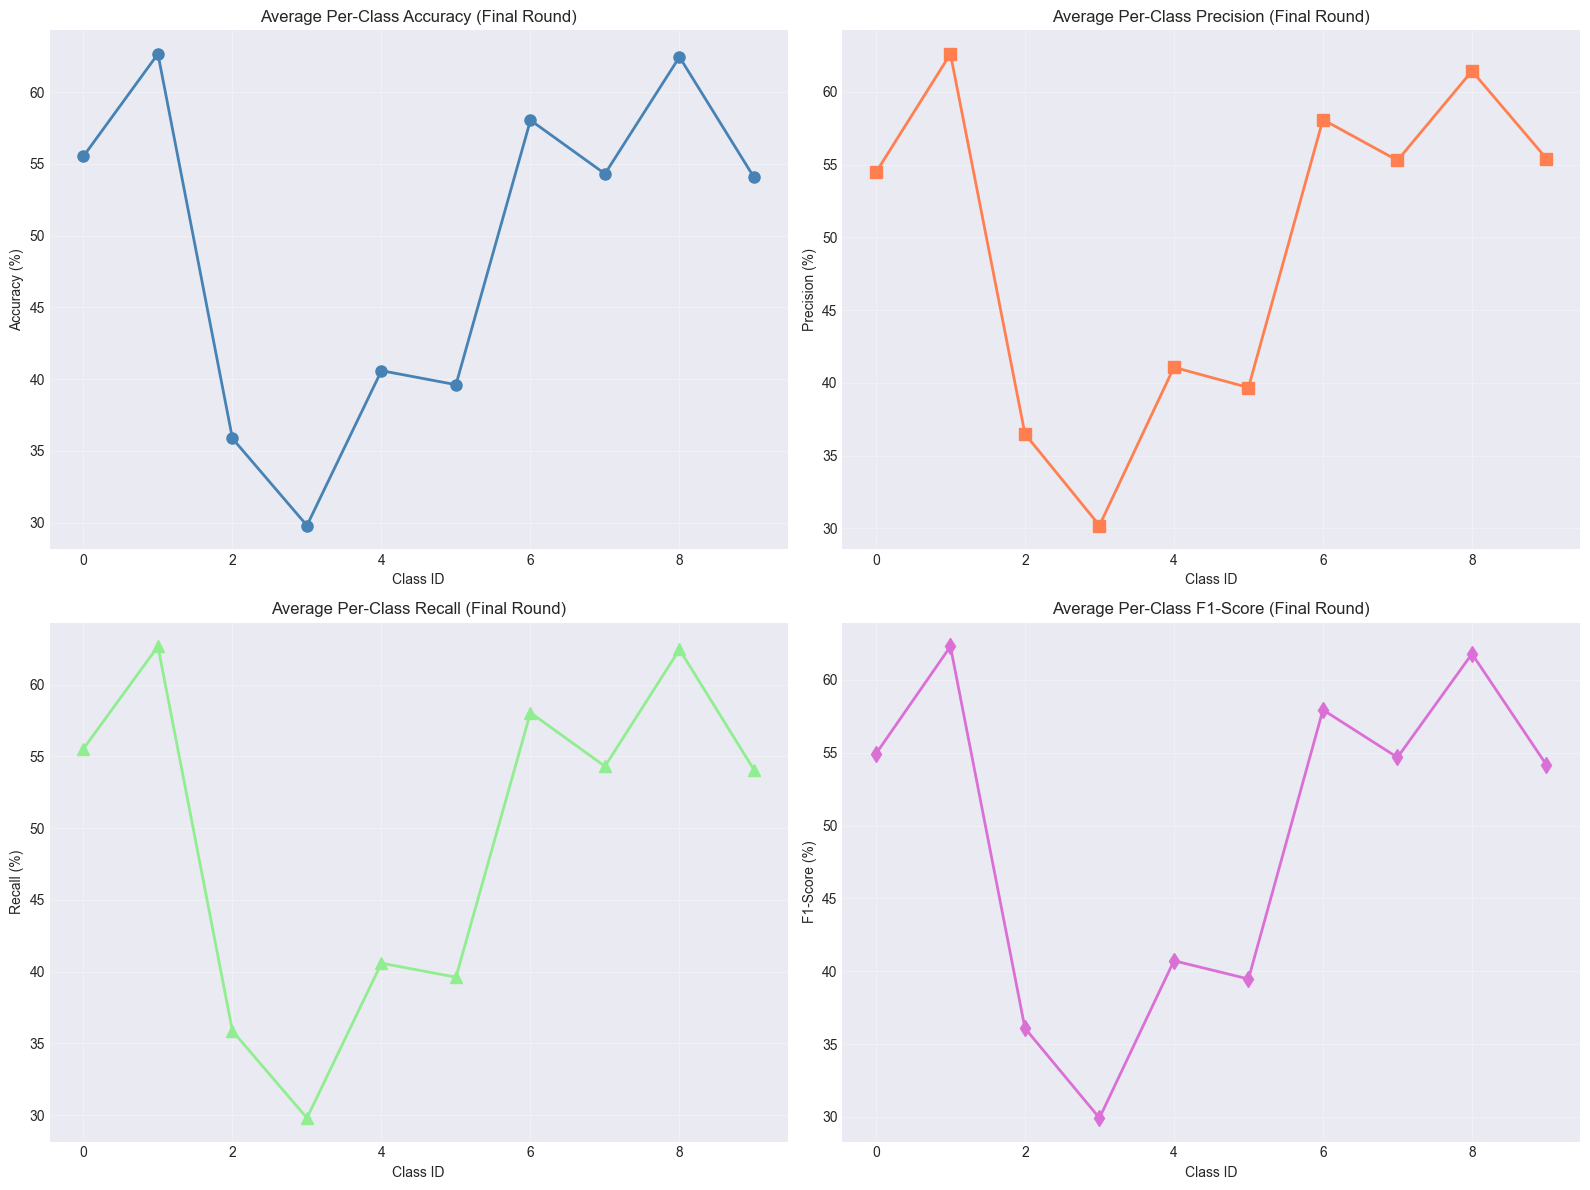

          class_accuracy  class_precision  class_recall  class_f1_score
class_id                                                               
0                  55.54            54.47         55.54           54.93
1                  62.68            62.61         62.68           62.30
2                  35.86            36.50         35.86           36.09
3                  29.80            30.20         29.80           29.92
4                  40.59            41.07         40.59           40.72
5                  39.61            39.68         39.61           39.47
6                  58.05            58.10         58.05           57.95
7                  54.32            55.30         54.32           54.68
8                  62.46            61.44         62.46           61.80
9                  54.07            55.42         54.07           54.17

Average Per-Class Metrics (Final Round):


In [77]:
# Average metrics across all clients for final round
final_class_data = df_class[df_class['round'] == final_round]
avg_per_class = final_class_data.groupby('class_id').agg({
    'class_accuracy': 'mean',
    'class_precision': 'mean',
    'class_recall': 'mean',
    'class_f1_score': 'mean'
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(avg_per_class.index, avg_per_class['class_accuracy'], 
                marker='o', linewidth=2, color='steelblue', markersize=8)
axes[0, 0].set_xlabel('Class ID')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Average Per-Class Accuracy (Final Round)')
axes[0, 0].grid(True, alpha=0.3)

# Precision
axes[0, 1].plot(avg_per_class.index, avg_per_class['class_precision'], 
                marker='s', linewidth=2, color='coral', markersize=8)
axes[0, 1].set_xlabel('Class ID')
axes[0, 1].set_ylabel('Precision (%)')
axes[0, 1].set_title('Average Per-Class Precision (Final Round)')
axes[0, 1].grid(True, alpha=0.3)

# Recall
axes[1, 0].plot(avg_per_class.index, avg_per_class['class_recall'], 
                marker='^', linewidth=2, color='lightgreen', markersize=8)
axes[1, 0].set_xlabel('Class ID')
axes[1, 0].set_ylabel('Recall (%)')
axes[1, 0].set_title('Average Per-Class Recall (Final Round)')
axes[1, 0].grid(True, alpha=0.3)

# F1-Score
axes[1, 1].plot(avg_per_class.index, avg_per_class['class_f1_score'], 
                marker='d', linewidth=2, color='orchid', markersize=8)
axes[1, 1].set_xlabel('Class ID')
axes[1, 1].set_ylabel('F1-Score (%)')
axes[1, 1].set_title('Average Per-Class F1-Score (Final Round)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

plt.show()
print(avg_per_class.round(2))

print(f"\nAverage Per-Class Metrics (Final Round):")

## 7. Summary Statistics

In [78]:
print("=" * 80)
print("P2P FEDERATED LEARNING - EXPERIMENT SUMMARY")
print("=" * 80)

print(f"\n📊 OVERALL METRICS")
print("-" * 80)
print(f"  Clients: {df['client_id'].nunique()}")
print(f"  Rounds: {df['round'].max()}")
print(f"  Classes: {df_class['class_id'].nunique()}")

final_round = df['round'].max()
final_data = df[df['round'] == final_round]

print(f"\n🎯 FINAL ROUND PERFORMANCE (Round {final_round})")
print("-" * 80)
print(f"  Accuracy:")
print(f"    Mean: {final_data['test_accuracy'].mean():.2f}%")
print(f"    Std:  {final_data['test_accuracy'].std():.2f}%")
print(f"    Range: [{final_data['test_accuracy'].min():.2f}%, {final_data['test_accuracy'].max():.2f}%]")

print(f"\n  Loss:")
print(f"    Mean: {final_data['test_loss'].mean():.4f}")
print(f"    Std:  {final_data['test_loss'].std():.4f}")
print(f"    Range: [{final_data['test_loss'].min():.4f}, {final_data['test_loss'].max():.4f}]")

print(f"\n  Gradient Norm:")
print(f"    Mean: {final_data['gradient_norm'].mean():.4f}")
print(f"    Std:  {final_data['gradient_norm'].std():.4f}")

# Convergence analysis
first_round = df[df['round'] == 1]
accuracy_improvement = final_data['test_accuracy'].mean() - first_round['test_accuracy'].mean()
loss_improvement = first_round['test_loss'].mean() - final_data['test_loss'].mean()

print(f"\n📈 CONVERGENCE")
print("-" * 80)
print(f"  Accuracy Improvement: {accuracy_improvement:.2f}%")
print(f"  Loss Reduction: {loss_improvement:.4f}")

# Per-class summary
final_class_data = df_class[df_class['round'] == final_round]
print(f"\n📋 PER-CLASS PERFORMANCE (Average Across Clients)")
print("-" * 80)
avg_class_metrics = final_class_data.groupby('class_id').agg({
    'class_accuracy': 'mean',
    'class_precision': 'mean',
    'class_recall': 'mean',
    'class_f1_score': 'mean'
})
print(f"  Mean Accuracy: {avg_class_metrics['class_accuracy'].mean():.2f}%")
print(f"  Mean Precision: {avg_class_metrics['class_precision'].mean():.2f}%")
print(f"  Mean Recall: {avg_class_metrics['class_recall'].mean():.2f}%")
print(f"  Mean F1-Score: {avg_class_metrics['class_f1_score'].mean():.2f}%")

print("\n" + "=" * 80)
print(f"Results location: {experiment_dir}")
print("=" * 80)

P2P FEDERATED LEARNING - EXPERIMENT SUMMARY

📊 OVERALL METRICS
--------------------------------------------------------------------------------
  Clients: 40
  Rounds: 300
  Classes: 10

🎯 FINAL ROUND PERFORMANCE (Round 300)
--------------------------------------------------------------------------------
  Accuracy:
    Mean: 49.30%
    Std:  2.08%
    Range: [41.08%, 51.34%]

  Loss:
    Mean: 4.0597
    Std:  0.2355
    Range: [3.1923, 4.6287]

  Gradient Norm:
    Mean: 1.1007
    Std:  2.8387

📈 CONVERGENCE
--------------------------------------------------------------------------------
  Accuracy Improvement: 30.27%
  Loss Reduction: -1.8821

📋 PER-CLASS PERFORMANCE (Average Across Clients)
--------------------------------------------------------------------------------
  Mean Accuracy: 49.30%
  Mean Precision: 49.48%
  Mean Recall: 49.30%
  Mean F1-Score: 49.20%

Results location: logs\matcha_comparison\2026-02-06_15-42-30
